In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from typing import List


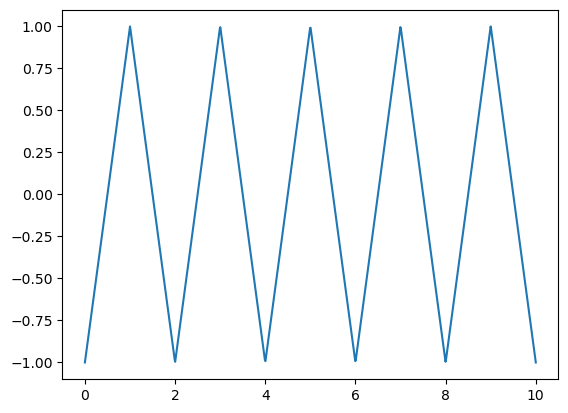

In [2]:
def tri(period: float, amplitude: float):
    """
    triangle wave function centered around 0 with period and amplitude
    """

    def triangle_wave_transform(x: torch.Tensor):
        # using sigal
        return (amplitude / period) * (
            (period - abs(x % (2 * period) - (1 * period)) - period / 2)
        )

    return triangle_wave_transform


# Plot sample trianlge wave
x = torch.linspace(0, 10, 1000)
y = tri(1, 2)(x)
plt.plot(x, y)


In [3]:
class PCN(nn.Module):
    def __init__(
        self,
        layers: List[int],
    ):
        super().__init__()
        self.weight_transform = tri(0.1, 20)
        if len(layers) < 2:
            raise ValueError("At least 2 layers are required")

        self.layers = nn.ParameterList(
            [nn.Parameter(torch.rand(l, 20) * 2 - 1) for l in layers]
        )
        self.layers_bias = nn.ParameterList(
            [nn.Parameter((torch.rand(l, 1) * 2 - 1) * 0.1) for l in layers]
        )

    def forward(self, x: torch.Tensor):
        z = x
        for i, (l, lnext) in enumerate(zip(self.layers, self.layers[1:])):
            z = (
                z @ (self.weight_transform(torch.cdist(l, lnext)) / l.shape[0])
            ) + self.layers_bias[i + 1].T
            if i < len(self.layers) - 2:
                z = torch.relu(z)
        return z


# control model
class FCN(nn.Module):
    def __init__(
        self,
        n_in: int,
        n_out: int,
        hidden: List[int],
    ):
        super().__init__()

        c = n_in
        L = []
        for l in hidden:
            L.append(nn.Linear(c, l))
            L.append(nn.ReLU())
            c = l

        L.append(nn.Linear(l, n_out))
        self.net = nn.Sequential(*L)

    def forward(self, x):
        return self.net(x)


In [4]:
pcn = PCN([28 * 28, 100, 100, 100, 100, 10])
fcn = FCN(28 * 28, 10, [100, 100, 100, 100, 100, 100, 100, 100])

pcn(torch.rand(1, 28 * 28)), fcn(torch.rand(1, 28 * 28))


(tensor([[-0.0733, -0.0078, -0.0061, -0.0436,  0.0840,  0.0315, -0.0205,  0.0026,
           0.0012,  0.0399]], grad_fn=<AddBackward0>),
 tensor([[-0.0300,  0.0966, -0.0438, -0.0380,  0.0787,  0.0653,  0.0724,  0.0293,
          -0.0404,  0.0621]], grad_fn=<AddmmBackward0>))

Here we are confirming that our PCN processes & outputs data similarly to our FCN.


In [5]:
import shutil

shutil.rmtree("log_dir", ignore_errors=True)

import shutil
import tempfile
shutil.rmtree(tempfile.gettempdir() + "/.tensorboard-info", ignore_errors=True) # sort of 'force reload' for tensorboard
%load_ext tensorboard 
%tensorboard --logdir log_dir --reload_interval 1 --port 6005

In [6]:
shutil.rmtree("log_dir", ignore_errors=True)


In [7]:
import sys

sys.path.append("..")
from datasets import load_data, MNIST

train = load_data(MNIST("train"))
test = load_data(MNIST("test"))

In [ ]:
import torch.utils.tensorboard as tb

log_dir = "log_dir"
learn_rate = 0.01
epochs = 100

pcn_logger = tb.SummaryWriter(log_dir + "/pcn")
fcn_logger = tb.SummaryWriter(log_dir + "/fcn")

pcn = PCN([28 * 28, 100, 100, 100, 100, 10])
fcn = FCN(28 * 28, 10, [100, 100, 100, 100])

optimzer_pcn = torch.optim.SGD(pcn.parameters(), lr=0.001)
optimzer_fcn = torch.optim.SGD(fcn.parameters(), lr=learn_rate)
loss = nn.CrossEntropyLoss()

step = 0
for epoch in range(epochs):
    for i, (x, y) in enumerate(train):
        x = x.float()
        y = y
        pcn_pred = pcn(x).float()
        fcn_pred = fcn(x).float()
        pcn_loss = loss(pcn_pred, y)
        fcn_loss = loss(fcn_pred, y)

        pcn_loss.backward()
        fcn_loss.backward()

        optimzer_pcn.step()
        optimzer_pcn.zero_grad()
        optimzer_fcn.step()
        optimzer_fcn.zero_grad()

        pcn_logger.add_scalar("loss", pcn_loss, step)
        fcn_logger.add_scalar("loss", fcn_loss, step)

        step += 1

    correct_pcn = 0
    total_pcn = 0

    correct_fcn = 0
    total_fcn = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test):
            x = x.float()
            y = y.float()
            pcn_pred = pcn(x).float()
            fcn_pred = fcn(x).float()

            correct_pcn += (pcn_pred.argmax(dim=1) == y).sum().item()
            total_pcn += y.shape[0]

            correct_fcn += (fcn_pred.argmax(dim=1) == y).sum().item()
            total_fcn += y.shape[0]

    # print(f"Epoch {epoch} Accuracy: {correct/total}")
    pcn_logger.add_scalar("accuracy", correct_pcn / total_pcn, epoch)
    fcn_logger.add_scalar("accuracy", correct_fcn / total_fcn, epoch)


We will conclude the experiment here. We have got a functioning, training version of a PCN. We compare it's loss & test accuracy convergence to an equally shaped FCN. Note that although the shape of the FCN & PCN are the same, the PCN has far fewer parameters than the FCN.

$$|\theta_{FCN}| = 28 * 28 * 100 + 3 * 100 * 100 + 100 * 10 = 109400$$

$$|\theta_{PCN}| = (28 * 28 + 4 * 100 + 10) * (20 + 1) = 25074$$

For this specific PCN, we used a dimensionality of 20 for the points, and give each point a bias term as well (hence the $20 + 1$). We hope that in the future we can lower the dimensionality to 1 without losing too much accuracy, or at least apply some rigour to our choice of dimensionality (perhaps a dynamic dimensionality based on the current/previous/next layer size).

We see that the PCN takes much more time to converge. We can observe that the PCN seems to be converging to an accuracy close to, but clearly below that of the FCN. Specifically, the FCN very quickly converges to an accuracy just below 97.7%, and the PCN converges to an accuracy above 97.3%, giving us a delta of 0.4%.

The significance of that delta is unclear at the moment and will require much more testing on different datasets, different choices for PCN's and different choices for FCN's. Before that though, we need to make our PCN much more sturdy. In this experiment, here are the critical hyperparameters we used for our PCN:

- 4 hidden layers
- 100 neurons per hidden layer
- triangle wave period of 0.1
- trianlge wave amplitude of 20
- learn rate of 0.001

At the moment, our PCN is highly sensitive to all of these hyperparameters in regard to whether it will train properly or not. In order to do more rigorous testing, we have to go back, analyze every step of our PCN in regard to these hyperparameters, and normalize, regularize, stabalize, normalize some more, etc. our PCN. This will be the focus of the next experiment, and will hopefully lead to some very exciting results as we gain the ability to scale up our PCN.
